In [52]:
import os
import sopa
import spatialdata
import scanpy as sc
import squidpy as sq
import pandas as pd
import seaborn as sns
import spatialdata as sd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [53]:
""" ####################################################### """
""" _____________  Introducing The Parameters ______________"""
""" ####################################################### """

Tissue = "Region4"
TableFolder = "REGION4_TABLES"

out_path = f"/Volumes/ProstateCancerEvo_SpatialAnalysis/dbs/Ongoing/{Tissue}/{TableFolder}"
os.makedirs(out_path, exist_ok=True)

xenium_p_file = f"{out_path}/{Tissue}_Xenium_Phen_HE_Integrated.Protein_PhenCycTable.V1.h5ad"
phen_adata_file = f"{out_path}/{Tissue}_Xenium_Phen_HE_Integrated.GeneTranscripts_XStock_Process.V1.h5ad"

clust_dir = os.path.join(out_path, "CLUST_UMAP_QC_ANN")

os.makedirs(clust_dir, exist_ok=True)

adata_xenium_p = sc.read_h5ad(phen_adata_file)
adata_pheno = sc.read_h5ad(xenium_p_file)

top_genes = 2000
flavor_chosen = "seurat"

Negative DNA probe count % : 0.0005268844359598538
Negative decoding count % : 0.00043907036329987815


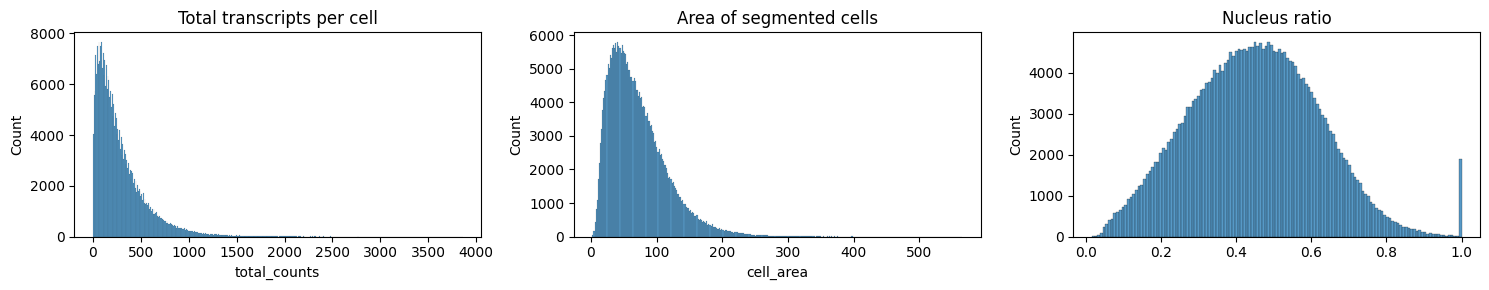

In [54]:

""" ####################################################### """
""" __________________________ QC __________________________"""
""" ####################################################### """


sc.pp.calculate_qc_metrics(adata_xenium_p, percent_top=(10, 20, 50, 150), inplace=True)

cprobes = (
    adata_xenium_p.obs["control_probe_counts"].sum() / adata_xenium_p.obs["total_counts"].sum() * 100
)
cwords = (
    adata_xenium_p.obs["control_codeword_counts"].sum() / adata_xenium_p.obs["total_counts"].sum() * 100
)


print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")


fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata_xenium_p.obs["total_counts"],
    kde=False,
    ax=axs[0],
)


axs[1].set_title("Area of segmented cells")
sns.histplot(
    adata_xenium_p.obs["cell_area"],
    kde=False,
    ax=axs[1],
)

axs[2].set_title("Nucleus ratio")
sns.histplot(
    adata_xenium_p.obs["nucleus_area"] / adata_xenium_p.obs["cell_area"],
    kde=False,
    ax=axs[2],
)
os.makedirs("figures", exist_ok=True)
fig.tight_layout()
fig.savefig("figures/QC.png", dpi=300, bbox_inches="tight")


In [55]:

""" ###################################################################################### """
""" ___________ PhenoCycler Z - Score Annotation in terms of Biomarkers on UMAP ___________"""
""" ###################################################################################### """

marker_cell_dict_cells = {
'1': 'CD8', 
'2': 'CD31', 
'3': 'CD11c', 
'4': 'CD34', 
'5': 'CD20', 
'6': 'CD4', 
'7': 'CD21', 
'8': 'Ki67', 
'9': 'CD68', 
'10': 'E-cadherin', #Luminal Epithelial and Adenocarcinoma Cells
'11': 'pten', 
'12': 'NF-H', # Glandular 
'13': 'FOXp3', 
'14': 'CD45', 
'15': 'TFAM', 
'16': 'PDL-1', 
'17': 'SOX2', 
'18': 'Vimentin', 
'19': 'HIF1A', 
'20': 'CD44', 
'21': 'Keratin 8/18', #'Luminal epithelial cell (CK8/18⁺)',
'22': 'aSMA', #'Smooth muscle cell / myofibroblast', 
'24': 'K14'#'Basal epithelial cell (K14⁺)'
}

#Find the enriched cells by specific marker genes from PhenoCycler data
sopa.utils.higher_z_score(adata_pheno, marker_cell_dict_cells)

# Record as cell_type
adata_xenium_p.obs["cell_type"] = (
    adata_pheno
         .obs["cell_type"]
         .values
)

# now that obs has two columns: cell_id & cell_type
adata_xenium_p.obs["cell_type"]

[INFO] (sopa.utils.annotation) Annotation counts: cell_type
Keratin 8/18    49704
aSMA            39079
E-cadherin      29873
PDL-1           27872
Ki67            18784
FOXp3           16879
CD34            16130
CD68            13242
Vimentin        11340
CD31            11067
CD44             9592
pten             8927
CD45             7786
K14              7214
TFAM             7190
CD21             6609
CD11c            5335
CD8              5231
NF-H             4757
SOX2             4553
CD20             3444
CD4              2741
HIF1A            2654
Name: count, dtype: int64


0                  CD8
1                PDL-1
2                 TFAM
3                 TFAM
4                 TFAM
              ...     
309998      E-cadherin
309999      E-cadherin
310000            CD44
310001           CD11c
310002    Keratin 8/18
Name: cell_type, Length: 310003, dtype: object

/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:243: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:536: UserWarning: Ignoring svd_solver='argpack' and using arpack, sklearn.decomposition._pca.PCA only supports dict_keys(['auto', 'full', 'randomized', 'arpack', 'covariance_eigh']).
  warnings.warn(msg)


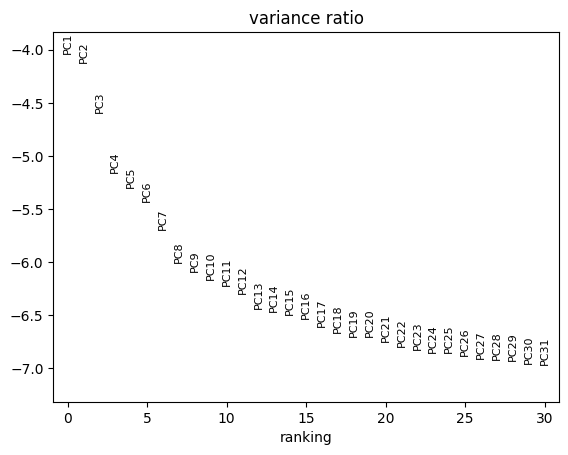

In [56]:

""" ###################################################################################### """
""" _______________________ Pre - Filtering Of Less Variable Genes  _______________________"""
""" ###################################################################################### """

# 1. Normalize to counts per 10 000 spots per cell (CP10K)
sc.pp.normalize_total(adata_xenium_p, target_sum=1e4)

# 2. Log‐transform
sc.pp.log1p(adata_xenium_p)

# 3. Find highly variable genes (HVGs)
sc.pp.highly_variable_genes(
    adata_xenium_p,
    n_top_genes=top_genes,
    flavor=flavor_chosen
)
#adata_xenium_p = adata_xenium_p[:, adata_xenium_p.var.highly_variable] ### NOT: DANININ KUYRUGU BURADA KOPUYOR
sc.pp.scale(adata_xenium_p, max_value=10) # Doesn't allow to dominate outlier genes

sc.tl.pca(adata_xenium_p, svd_solver = "argpack")
sc.pl.pca_variance_ratio(adata_xenium_p, log=True, save = f"_{Tissue}.png")



# 2. LEIDEN + UMAP
sc.pp.neighbors(adata_xenium_p, n_neighbors=15, n_pcs=40) # includes elbow plot calculation
sc.tl.leiden(adata_xenium_p, resolution=1, key_added="leiden")
sc.tl.umap(adata_xenium_p)

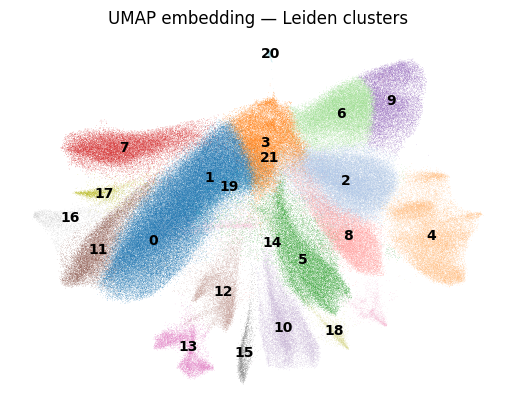

In [57]:

""" ###################################################################################### """
""" _______________________ Plotting UMAP and Leiden Clusters _______________________"""
""" ###################################################################################### """
sc.pl.umap(
    adata_xenium_p,
    color="leiden",
    palette="tab20",
    title="UMAP embedding — Leiden clusters",
    legend_loc="on data",
    frameon=False,
    save = f"_Transcriptome_{Tissue}.png"
)


/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encounter

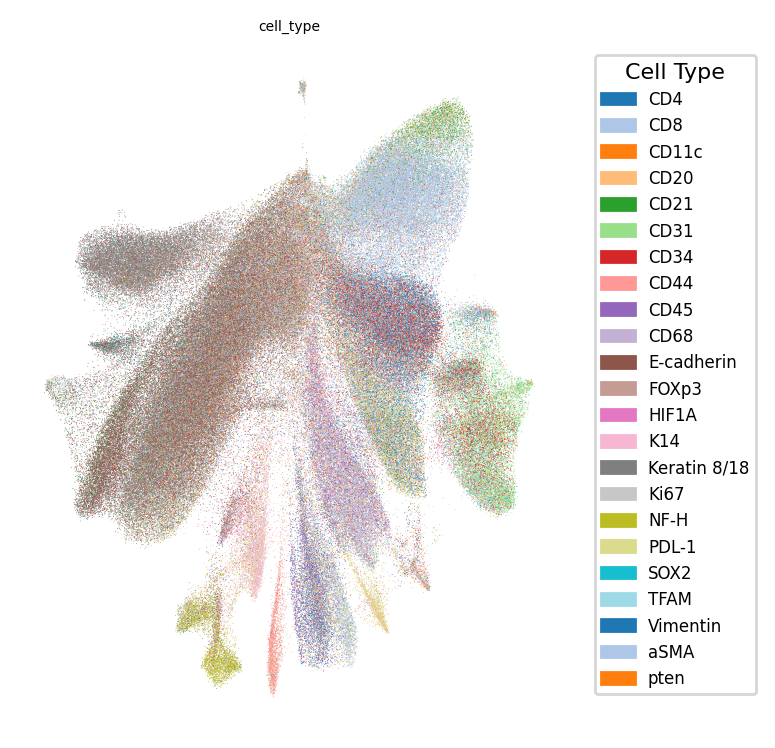

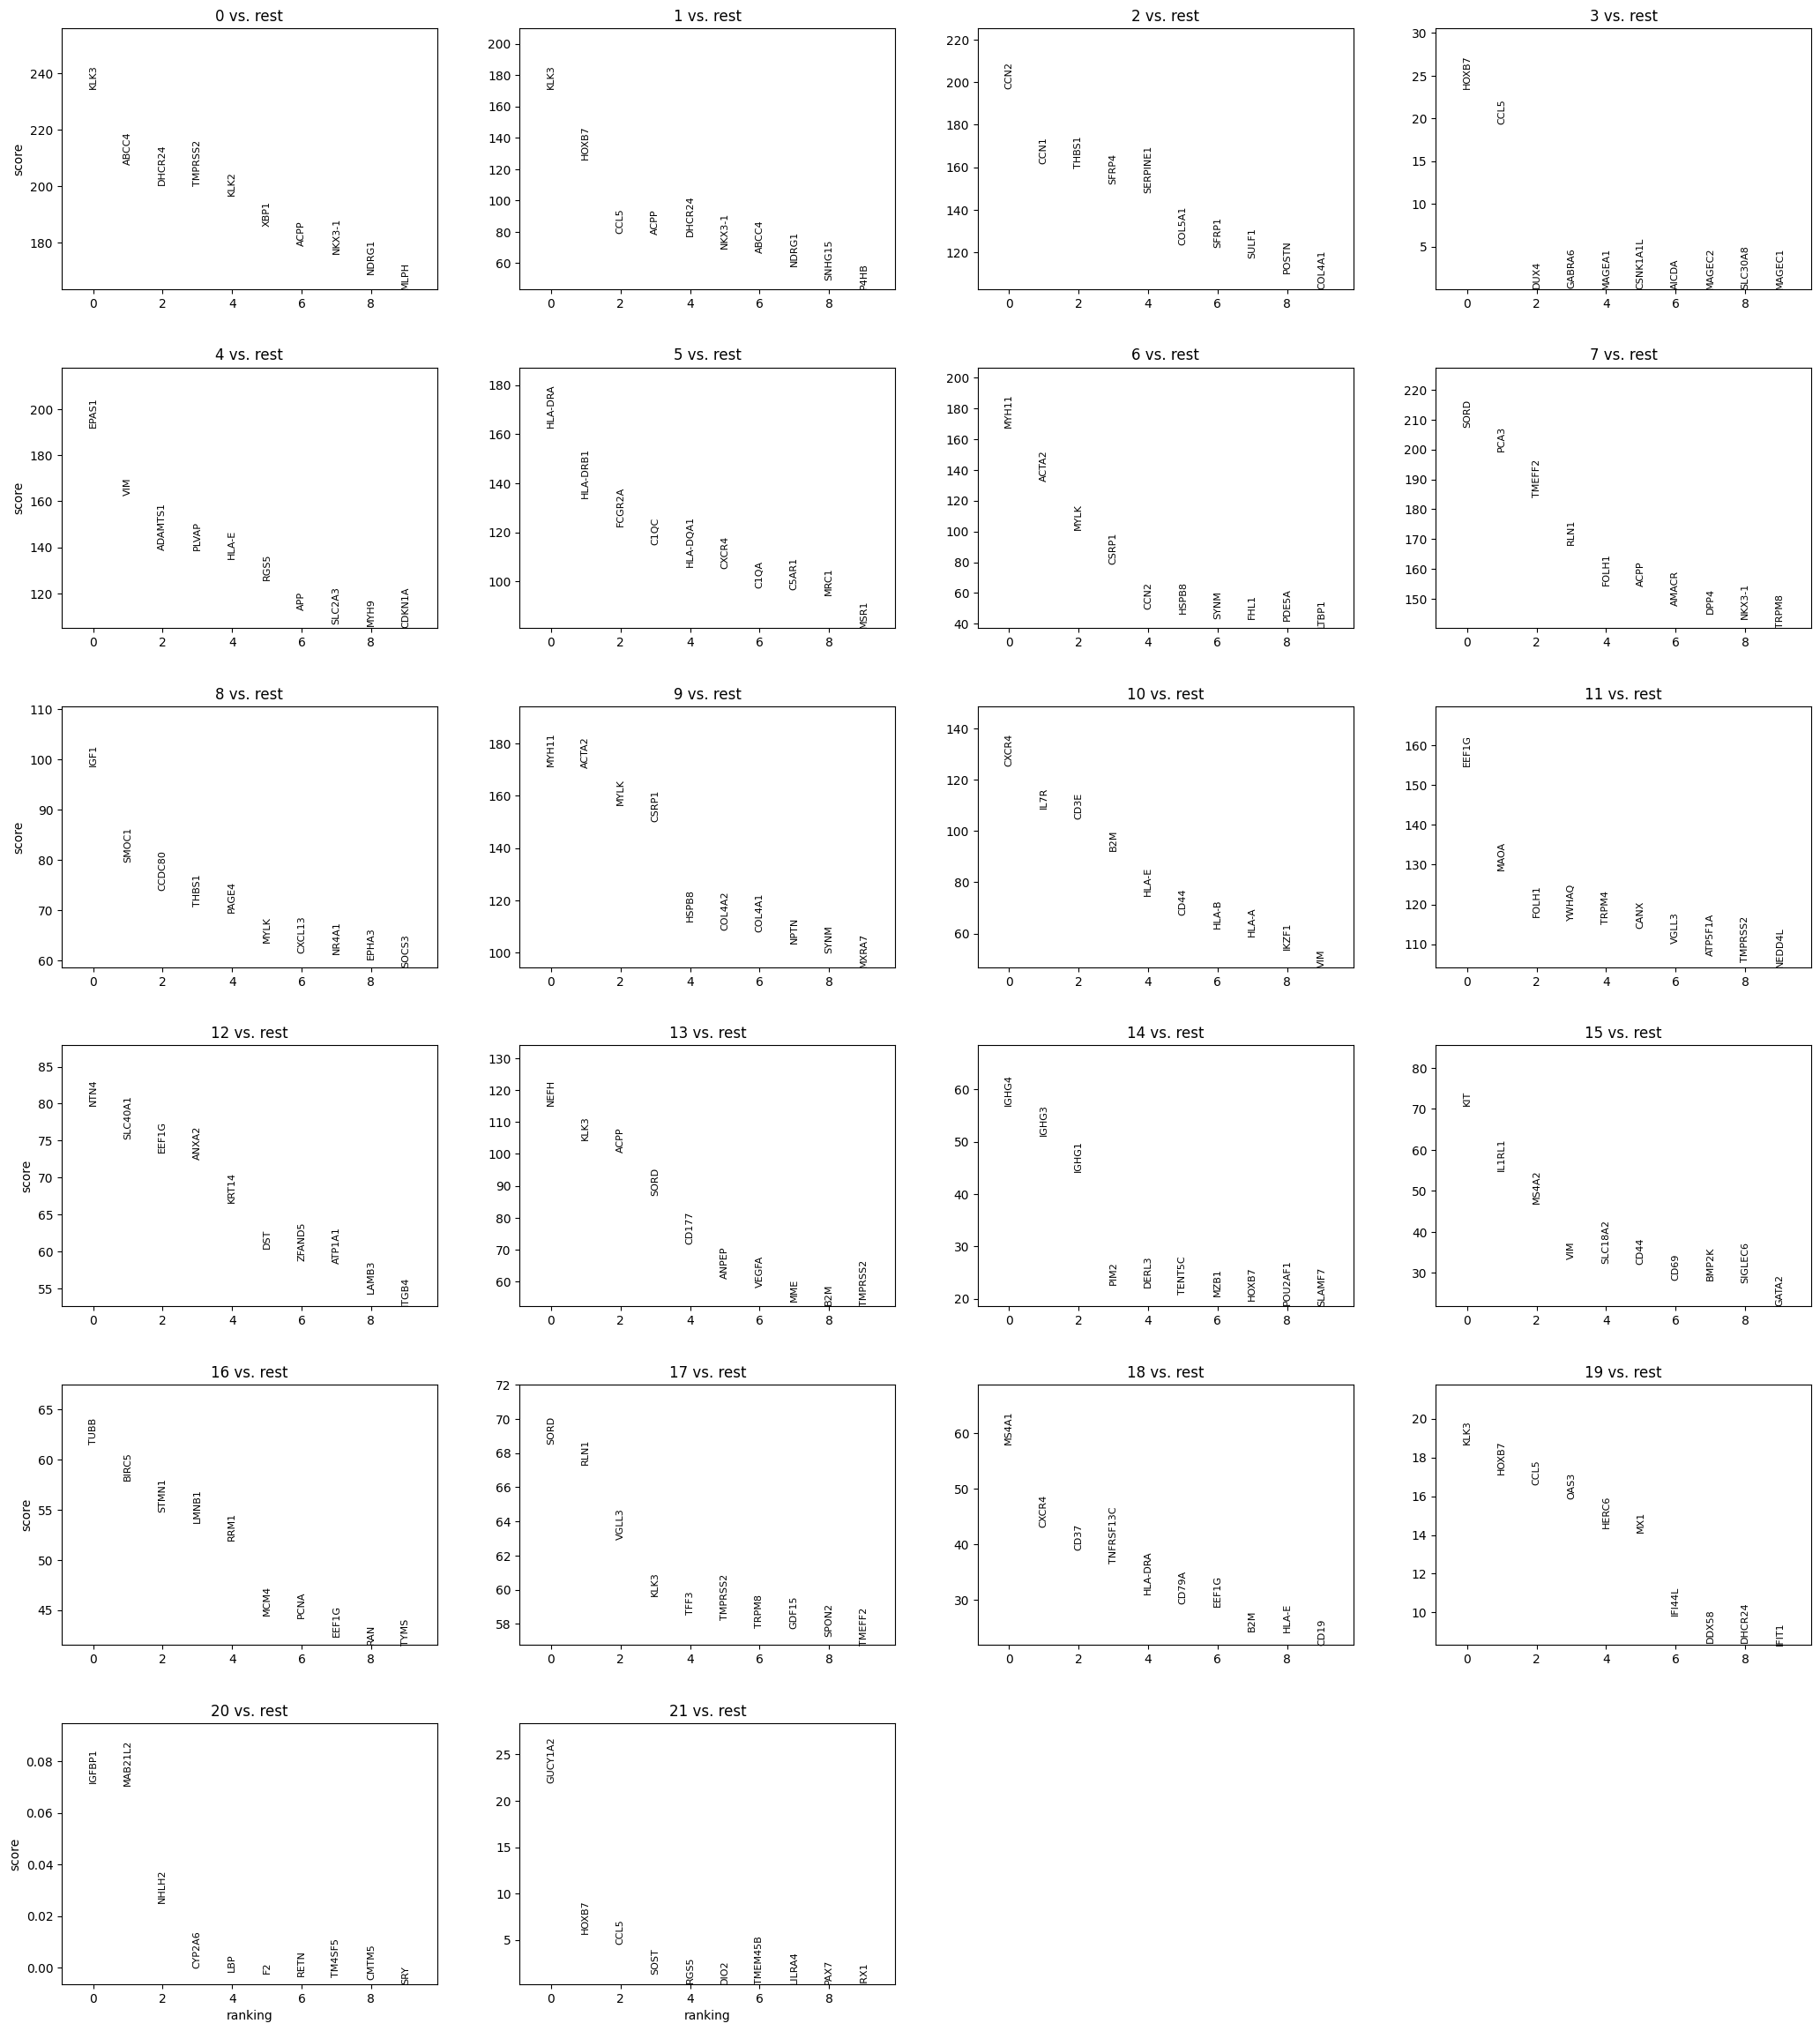

In [58]:

""" ###################################################################################### """
""" _____________ PhenoCycler Biomarkers enriched UMAP done by Transcriptome  _____________"""
""" ###################################################################################### """


cat_order = adata_xenium_p.obs['cell_type'].cat.categories.tolist()

palette = sns.color_palette("tab20", n_colors=len(cat_order)).as_hex()
adata_xenium_p.obs['cell_type'] = adata_xenium_p.obs['cell_type'].astype('category')
cat_order = adata_xenium_p.obs['cell_type'].cat.categories.tolist()


colors = palette  # list of colors in the same order as cat_order

# 3) Plot UMAP into a new Figure/Axes
fig, ax = plt.subplots(figsize=(4,4), dpi=200)
sc.pl.umap(
    adata_xenium_p,
    color='cell_type',
    palette=colors,
    ax=ax,
    show=False,
    frameon=False
)

if ax.get_legend() is not None:
    ax.get_legend().remove()

handles = [
    mpatches.Patch(color=colors[i], label=cat_order[i])
    for i in range(len(cat_order))
]
leg = ax.legend(
    handles=handles,
    title='Cell Type',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=6,
    title_fontsize=8
)

ax.tick_params(labelsize=3)
ax.title.set_fontsize(5)

plt.tight_layout()
plt.savefig(os.path.join(f"figures/{Tissue}_UMAP_enrichedPhenoCyclerBiomarkers.png"), dpi=300, bbox_inches="tight")


#### SPLITS THE CELLS IN AND OUT CLUSTER COM
# 5. Rank “Xenium spot counts” per Leiden group
sc.tl.rank_genes_groups(
    adata_xenium_p,
    groupby="leiden",
    method="wilcoxon",
    key_added="rank_leiden"
)

sc.pl.rank_genes_groups(
    adata_xenium_p,
    key="rank_leiden",
    n_genes=10,
    sharey=False,
    save = f"_{Tissue}.png"
)



/var/folders/4p/7h_929nx5qngrf9z7xhfy15w0000gn/T/ipykernel_68661/3412191235.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group")["names"]


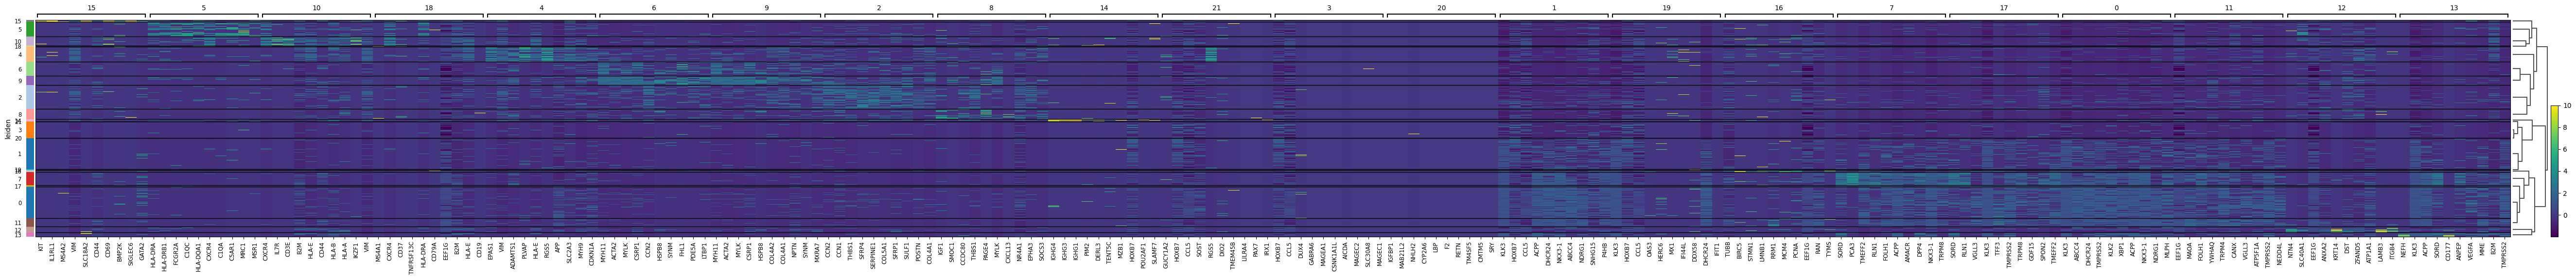

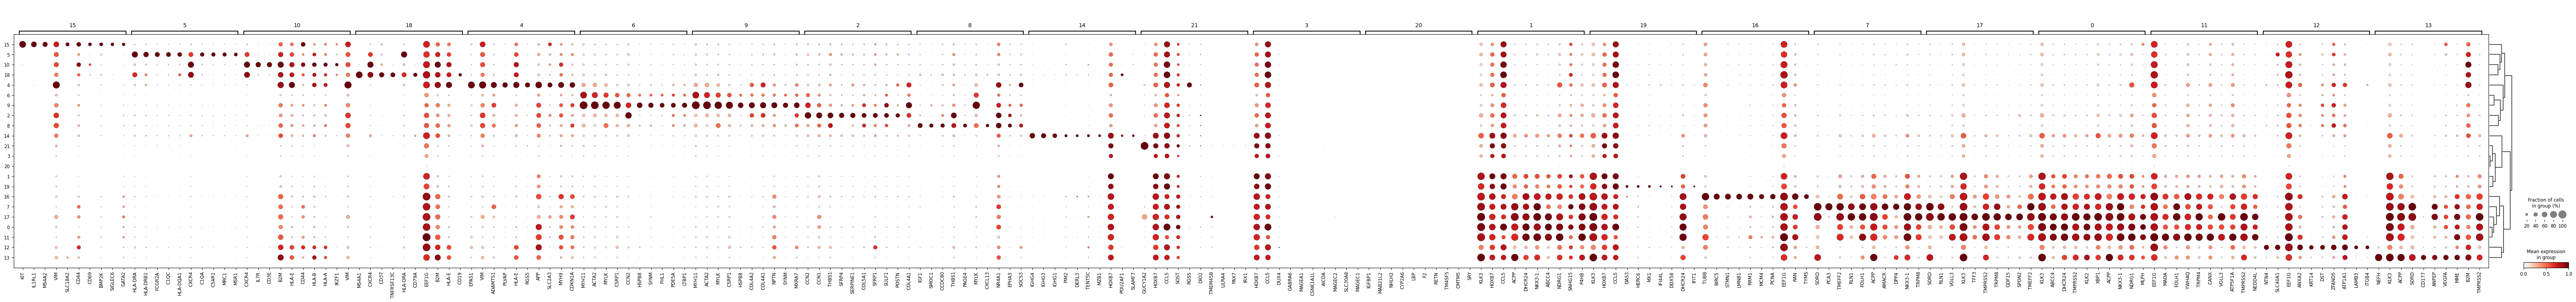

/Volumes/ProstateCancerEvo_SpatialAnalysis/dbs/Ongoing/Region4/REGION4_TABLES/Region4_Xenium_Phen_HE_Integrated.Xenium_Process_Table.V2.All_Genes.h5ad


OSError: [Errno 28] Can't synchronously write data (file write failed: time = Sun May 25 20:21:37 2025
, filename = '/Volumes/ProstateCancerEvo_SpatialAnalysis/dbs/Ongoing/Region4/REGION4_TABLES/Region4_Xenium_Phen_HE_Integrated.Xenium_Process_Table.V2.All_Genes.h5ad', file descriptor = 91, errno = 28, error message = 'No space left on device', buf = 0x410000000, total write size = 6325301212, bytes this sub-write = 2147483647, offset = 6144)

In [59]:

""" ###################################################################################### """
""" _____________________________ Leiden Cluster Specific Groups  _________________________"""
""" ###################################################################################### """

# 1) Flatten all DE results into a DataFrame
df = sc.get.rank_genes_groups_df(
    adata_xenium_p,
    group=None,           # None = include every Leiden cluster
    key="rank_leiden"     # the key you used when running rank_genes_groups
)                     

# 2) For each cluster, take the first 7 genes
top7 = (
    df
      .groupby("group")["names"]
      .apply(lambda genes: genes.iloc[:7].tolist())
)

# 3) Convert to a  table
df_top7 = pd.DataFrame({
    f"cluster_{grp}": genes 
    for grp, genes in top7.items()
})

df_top7 = df_top7[sorted(df_top7.columns, key=lambda x: int(x.split("_")[1]))]

df_top7

# 6. Visualize top markers
sc.pl.rank_genes_groups_heatmap(
    adata_xenium_p,
    key="rank_leiden",
    groupby="leiden",
    n_genes=10,
    swap_axes=False,
    show_gene_labels=True,
    dendrogram=True,
    save = f"_{Tissue}.png"
)


sc.pl.rank_genes_groups_dotplot(
    adata_xenium_p,
    key="rank_leiden",
    groupby="leiden",
    n_genes=10,
    standard_scale="var",
    save = f"_{Tissue}.png"
)


# Record the UMAP introduced anndata
print(f"{out_path}/{Tissue}_Xenium_Phen_HE_Integrated.Xenium_Process_Table.V2.All_Genes.h5ad")
adata_xenium_p.write_h5ad(f"{out_path}/{Tissue}_Xenium_Phen_HE_Integrated.Xenium_Process_Table.V2.All_Genes.h5ad")


In [62]:


# Record the UMAP introduced anndata
print(f"{out_path}/{Tissue}_Xenium_Phen_HE_Integrated.Xenium_Process_Table.V2.All_Genes.h5ad")
adata_xenium_p.write_h5ad(f"{out_path}/{Tissue}_Xenium_Phen_HE_Integrated.Xenium_Process_Table.V2.All_Genes.h5ad")


/Volumes/ProstateCancerEvo_SpatialAnalysis/dbs/Ongoing/Region4/REGION4_TABLES/Region4_Xenium_Phen_HE_Integrated.Xenium_Process_Table.V2.All_Genes.h5ad


In [ ]:
# """ ###################################################################################### """
# """ _______________________________ UMAP Build By PhenoCycler  ____________________________"""
# """ ###################################################################################### """
# sc.pp.normalize_total(adata_pheno)
# sc.pp.log1p(adata_pheno)
# sc.pp.pca(adata_pheno)
# sc.pp.neighbors(adata_pheno)
# sc.tl.umap(adata_pheno)
# sc.tl.leiden(adata_pheno, resolution=0.1)


# sc.pl.umap(
#     adata_pheno,
#     color='cell_type',
#     palette="tab20",
#     title='UMAP by z-score enriched protein markers',
#     legend_loc='right margin',
#     frameon=False,
#     save = f"_{Tissue}_UMAP_doneByPhenoCycler.png"
# )

# # You didn't get output of
# adata_pheno.write_h5ad(f"{out_path}/{Tissue}_Xenium_Phen_HE_Integrated.Protein_PhenCycTable.V2.h5ad")

In [ ]:
import shutil
shutil.move("figures", clust_dir)

'/Volumes/ProstateCancerEvo_SpatialAnalysis/dbs/Ongoing/Region3/REGION3_TABLES/CLUST_UMAP_QC_ANN/figures'

In [ ]:
#!rm -rf '/Volumes/ProstateCancerEvo_SpatialAnalysis/dbs/Ongoing/Region2/REGION2_TABLES/CLUST_UMAP_QC_ANN/figures'
# adata_pheno.X

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Make sure adata_pheno is loaded (e.g. via anndata.read_h5ad or similar)
# # data = adata_pheno.X

# data = adata_pheno.X
# # If it’s a sparse matrix, convert to dense
# if hasattr(data, "toarray"):
#     data = data.toarray()

# # Flatten to 1D
# flat_vals = data.flatten()

# plt.figure()
# plt.hist(flat_vals, bins=50)
# plt.xlabel("Expression value")
# plt.ylabel("Frequency")
# plt.title("Distribution of all values in adata_pheno.X")
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 1. Grab your data matrix
# data = adata_pheno.X
# # If it’s sparse, convert to dense
# if hasattr(data, "toarray"):
#     data = data.toarray()

# # 2. Compute per‐cell (row) standard deviation
# row_std = np.std(data, axis=1)

# # 3. Plot the distribution of those std values
# plt.figure()
# plt.hist(row_std, bins=50)
# plt.xlabel("Per-cell standard deviation")
# plt.ylabel("Number of cells")
# plt.title("Distribution of per-cell (row) std in adata_pheno.X")
# plt.show()

In [ ]:
# import numpy as np
# import scipy.sparse as sp
# import pandas as pd

# # 1. Compute per‐cell max
# X = adata_pheno.X
# if sp.issparse(X):
#     row_max = X.max(axis=1).toarray().ravel()
# else:
#     row_max = np.max(X, axis=1)

# low_expression_cells = row_max <= 8
# print(f"{low_expression_cells.sum()} cells will be relabeled to 'Unknown'.")

# # 2. Ensure 'cell_type' exists and is categorical
# if 'cell_type' not in adata_pheno.obs:
#     adata_pheno.obs['cell_type'] = pd.Categorical([])

# # 3. Add the new category by reassigning
# ct = adata_pheno.obs['cell_type'].cat.add_categories(['Unknown_6'])
# adata_pheno.obs['cell_type'] = ct

# # 4. Assign 'Unknown' to low‐expression cells
# adata_pheno.obs.loc[low_expression_cells, 'cell_type'] = 'Unknown_6'

# # 5. (Optional) Inspect new counts
# print(adata_pheno.obs['cell_type'].value_counts())

In [ ]:
# adata_xenium_p.obs["cell_type2"] = adata_pheno.obs["cell_type"].values

In [ ]:
# adata_xenium_p.obs["cell_type2"] 

In [ ]:
# import pandas as pd
# import plotly.express as px
# import matplotlib.pyplot as plt
# import matplotlib as mpl


# adata  = adata_xenium_p

# df = pd.DataFrame(
#     adata.obsm['X_umap'],
#     columns=['UMAP1', 'UMAP2'],
#     index=adata.obs_names
# ).copy()

# df['cell_type2'] = adata.obs['cell_type2'].astype(str)

# tab20 = [mpl.colors.rgb2hex(c) for c in plt.get_cmap('tab20').colors]

# fig = px.scatter(
#     df,
#     x='UMAP1',
#     y='UMAP2',
#     color='cell_type2',
#     title='UMAP embedding — Leiden clusters',
#     color_discrete_sequence=tab20,
#     hover_name=df.index,
#     width=1400,
#     height=1200
# )

# fig.update_traces(marker=dict(size=3, opacity=0.8))
# fig.update_layout(
#     legend_title_text='Leiden cluster',
#     legend=dict(
#         itemsizing='constant',
#         traceorder='normal',
#         bgcolor='rgba(255,255,255,0.5)',
#         x=1.02, y=1
#     ),
#     margin=dict(l=20, r=200, t=50, b=20)
# )

# fig.show()